In [1]:
# Install external dependencies if needed
%pip install requests pandas numpy matplotlib scipy openpyxl seaborn python-dotenv

Note: you may need to restart the kernel to use updated packages.


# 🏠 Quatt Heat Loss & Heating Curve Analysis

## 📋 Quick Start Guide

This notebook supports **two types of heating systems**:

### 🔵 Heat Pump Users (Quatt)
**Run these cells:**
1. ✅ Cell 1 - Install dependencies
2. ✅ Cell 2 - Fetch Quatt heat pump data
3. ⏭️ **Skip** Cell 2B
4. ✅ Run all analysis cells

### 🟠 Gas Heating Users (no heat pump yet)
**Run these cells:**
1. ✅ Cell 1 - Install dependencies
2. ⏭️ **Skip** Cell 2
3. ✅ **Cell 2B** - Fetch gas consumption data
4. ✅ Run all analysis cells

### 🟣 Users Transitioning (gas → heat pump)
**Run these cells:**
1. ✅ Cell 1 - Install dependencies
2. ✅ Cell 2 - Fetch Quatt heat pump data
3. ✅ **Cell 2B** - Fetch historical gas data
4. ✅ Run all analysis cells (you'll get comparison graphs!)

> ⚠️ **Important for transitioning users:** The date ranges for Cell 2 (heat pump) and Cell 2B (gas) should **not overlap**. Set Cell 2B's dates to the period *before* you switched to a heat pump, and Cell 2's dates to the period *after*.

---

## 📊 What This Notebook Does

- **Heat Loss Analysis**: Calculate your home's heat loss coefficient
- **Heating Curves**: Determine optimal heating curve (stooklijn)
- **COP Analysis**: Analyze heat pump efficiency (heat pump users only)
- **Comparison**: Compare gas vs heat pump performance (if both datasets available)
- **Hot Water Correction**: Automatically estimates and subtracts hot water gas usage based on summer baseline (gas users)

---

Let's get started! 👇

In [3]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import time
import os
from dotenv import load_dotenv

load_dotenv()

# ==========================================
# 1. CONFIGURATION
# ==========================================
HA_URL = os.getenv("HA_URL")
TOKEN = os.getenv("TOKEN")

# Define your period here
START_DATE = "2025-06-30"
END_DATE = "2026-02-13" 

# File names for storage
HOURLY_CSV = "quatt_hourly.csv"
DAILY_CSV = "quatt_daily.csv"
COMBINED_EXCEL = "quatt_insights_data.xlsx" 

# ==========================================
# 2. HELPER FUNCTIONS
# ==========================================
def get_quatt_data(date_str):
    url = f"{HA_URL}/api/services/quatt/get_insights?return_response=true"
    headers = {
        "Authorization": f"Bearer {TOKEN}",
        "content-type": "application/json",
    }
    payload = {
        "from_date": date_str,
        "timeframe": "day",
        "advanced_insights": True
    }
    response = requests.post(url, headers=headers, json=payload)
    response.raise_for_status()
    return response.json()

# ==========================================
# 3. LOAD HISTORY & DETERMINE MISSING DATES
# ==========================================
print("--- Checking for existing history ---")

if os.path.exists(DAILY_CSV):
    df_daily_history = pd.read_csv(DAILY_CSV)
    df_daily_history['date'] = pd.to_datetime(df_daily_history['date'])
    df_daily_history = df_daily_history.set_index('date')
    existing_dates = set(df_daily_history.index.date)
    print(f"Loaded {len(df_daily_history)} daily records.")
else:
    df_daily_history = pd.DataFrame()
    existing_dates = set()

if os.path.exists(HOURLY_CSV):
    df_hourly_history = pd.read_csv(HOURLY_CSV)
    df_hourly_history['timestamp'] = pd.to_datetime(df_hourly_history['timestamp'])
    df_hourly_history = df_hourly_history.set_index('timestamp')
    print(f"Loaded {len(df_hourly_history)} hourly records.")
else:
    df_hourly_history = pd.DataFrame()

start_dt = datetime.strptime(START_DATE, "%Y-%m-%d")
end_dt = datetime.strptime(END_DATE, "%Y-%m-%d")
all_dates = pd.date_range(start=start_dt, end=end_dt)
dates_to_fetch = [d for d in all_dates if d.date() not in existing_dates]

print(f"Need to fetch: {len(dates_to_fetch)} days")

# ==========================================
# 4. MAIN EXECUTION LOOP
# ==========================================
hourly_chunks_new = []
daily_records_new = []

if dates_to_fetch:
    print("\n--- Starting data collection ---")
    for current_date in dates_to_fetch:
        date_str = current_date.strftime("%Y-%m-%d")
        print(f"Fetching: {date_str}...", end=" ")
        try:
            json_response = get_quatt_data(date_str)
            data = json_response['service_response']
            
            # DEBUG: Print available fields for first fetch only
            if current_date == dates_to_fetch[0]:
                print(f"\n\n=== Available API fields ===")
                print(f"Keys in response: {list(data.keys())}")
                print("=" * 40 + "\n")
            
            daily_record = {
                "date": current_date, 
                "totalHpHeat": data.get("totalHpHeat", 0), 
                "totalHpElectric": data.get("totalHpElectric", 0),
                "totalBoilerHeat": data.get("totalBoilerHeat", 0),
                "totalBoilerGas": data.get("totalBoilerGas", 0),
                "averageCOP": data.get("averageCOP", None),  # Try to get from API
                "status": "ok"
            }

            # Get main graph
            df_main = pd.DataFrame(data.get('graph', []))
            
            # Get temperature graph and merge
            if not df_main.empty:
                df_temp = pd.DataFrame(data.get('outsideTemperatureGraph', []))
                if not df_temp.empty:
                    # Merge on timestamp
                    df_main = pd.merge(df_main, df_temp, on='timestamp', how='left')
                
                # Optional: merge other graphs
                df_water = pd.DataFrame(data.get('waterTemperatureGraph', []))
                if not df_water.empty:
                    df_main = pd.merge(df_main, df_water, on='timestamp', how='left')
                    
                df_room = pd.DataFrame(data.get('roomTemperatureGraph', []))
                if not df_room.empty:
                    df_main = pd.merge(df_main, df_room, on='timestamp', how='left')
                
                hourly_chunks_new.append(df_main)
                print("Success.")
            
            daily_records_new.append(daily_record)
        except Exception as e:
            print(f"Error: {e}")
        time.sleep(2) 
        
# ==========================================
# 5. MERGE & SAVE
# ==========================================
print("\n--- Processing and Saving ---")

# --- Finalize Hourly ---
if hourly_chunks_new:
    df_hourly_new = pd.concat(hourly_chunks_new, ignore_index=True)
    df_hourly_new['timestamp'] = pd.to_datetime(df_hourly_new['timestamp'])
    df_hourly_new = df_hourly_new.set_index('timestamp')
    df_hourly = pd.concat([df_hourly_history, df_hourly_new])
else:
    df_hourly = df_hourly_history

# --- Finalize Daily ---
if daily_records_new:
    df_daily_new = pd.DataFrame(daily_records_new)
    df_daily_new['date'] = pd.to_datetime(df_daily_new['date'])
    df_daily_new = df_daily_new.set_index('date')
    df_daily = pd.concat([df_daily_history, df_daily_new])
else:
    df_daily = df_daily_history

# Cleanup duplicates and sort for CSV
if not df_hourly.empty:
    df_hourly = df_hourly[~df_hourly.index.duplicated(keep='last')].sort_index()
    print(f"Writing to csv: {HOURLY_CSV}...")
    df_hourly.to_csv(HOURLY_CSV)

if not df_daily.empty:
    df_daily = df_daily[~df_daily.index.duplicated(keep='last')].sort_index()
    
    # Calculate average outside temperature for daily data
    if 'temperatureOutside' in df_hourly.columns:
        daily_avg_temp = df_hourly.groupby(df_hourly.index.date)['temperatureOutside'].mean()
        df_daily['avg_temperatureOutside'] = df_daily.index.map(lambda d: daily_avg_temp.get(d.date(), None))
    
    df_daily['totalHeatPerHour'] = (df_daily.get('totalHpHeat', 0).fillna(0) + df_daily.get('totalBoilerHeat', 0).fillna(0)) / 24
    
    # If averageCOP not from API, calculate it
    if 'averageCOP' not in df_daily.columns or df_daily['averageCOP'].isna().all():
        print("Calculating averageCOP from totalHpHeat / totalHpElectric...")
        df_daily['averageCOP'] = df_daily['totalHpHeat'] / df_daily['totalHpElectric']
        df_daily['averageCOP'] = df_daily['averageCOP'].replace([float('inf'), -float('inf')], 0)
    
    print(f"Writing to csv: {DAILY_CSV}...")
    df_daily.to_csv(DAILY_CSV)

# EXCEL SAVING
try:
    print(f"Writing to Excel: {COMBINED_EXCEL}...")
    
    df_h_export = df_hourly.copy()
    df_d_export = df_daily.copy()

    if not df_h_export.empty and df_h_export.index.tz is not None:
        df_h_export.index = df_h_export.index.tz_localize(None)
    
    if not df_d_export.empty and df_d_export.index.tz is not None:
        df_d_export.index = df_d_export.index.tz_localize(None)

    with pd.ExcelWriter(COMBINED_EXCEL, engine='openpyxl') as writer:
        if not df_h_export.empty:
            df_h_export.reset_index().to_excel(writer, sheet_name='Hourly Data', index=False)
        
        if not df_d_export.empty:
            df_d_export.reset_index().to_excel(writer, sheet_name='Daily Summary', index=False)
            
    print("Excel saved successfully.")

except PermissionError:
    print(f"\n!!! WARNING: Could not save Excel. File is open in another program. !!!")
except Exception as e:
    print(f"An error occurred while saving Excel: {e}")

print("\nComplete!")

--- Checking for existing history ---
Need to fetch: 229 days

--- Starting data collection ---
Fetching: 2025-06-30... 

=== Available API fields ===
Keys in response: ['from', 'to', 'totalHpHeat', 'totalHpElectric', 'totalBoilerHeat', 'totalBoilerGas', 'averageCOP', 'savingsMoney', 'savingsCo2', 'savingsGas', 'savingsGasMoney', 'savingsQuattElectricityCost', 'co2GasSaved', 'co2Electricity', 'hasTarrifs', 'graph', 'outsideTemperatureGraph', 'waterTemperatureGraph', 'roomTemperatureGraph']

Success.
Fetching: 2025-07-01... Success.
Fetching: 2025-07-02... Success.
Fetching: 2025-07-03... Success.
Fetching: 2025-07-04... Success.
Fetching: 2025-07-05... Success.
Fetching: 2025-07-06... Success.
Fetching: 2025-07-07... Success.
Fetching: 2025-07-08... Success.
Fetching: 2025-07-09... Success.
Fetching: 2025-07-10... Success.
Fetching: 2025-07-11... Success.
Fetching: 2025-07-12... Success.
Fetching: 2025-07-13... Success.
Fetching: 2025-07-14... Success.
Fetching: 2025-07-15... Success.


In [37]:
# ==========================================
# CELL 2B: GAS CONSUMPTION DATA COLLECTION
# ==========================================
# Run this cell ONLY if you use gas heating (no heat pump) or want to compare
# historical gas data with your current heat pump setup.
#
# ⚠️ IMPORTANT: If you also run Cell 2 (heat pump data), make sure the date
# ranges do NOT overlap. Use Cell 2B for the period BEFORE your heat pump,
# and Cell 2 for the period AFTER.
#
# Hot water correction: Gas usage during warm days (above HOT_WATER_OUTSIDE_TEMP_THRESHOLD)
# is assumed to be hot water only. This baseline is subtracted from all days
# to isolate space heating demand.

import requests
import pandas as pd
from datetime import datetime, timedelta
import time
import os
from dotenv import load_dotenv

load_dotenv()

print("="*60)
print("GAS CONSUMPTION DATA COLLECTION")
print("="*60)

# ==========================================
# CONFIGURATION
# ==========================================
# Gas meter entity from Home Assistant
# Common entity names: "sensor.gas_consumption", "sensor.gas_meter", 
# "sensor.slimme_meter_gas_consumption", "sensor.youless_gas"
ENTITY_GAS = "sensor.slimmelezer_gas_consumed"  # ⚠️ CHANGE THIS to your gas meter entity

# Optional: Outside temperature entity (if different from heat pump)
# Leave as None to use weather integration data
ENTITY_TEMP_GAS = None  # e.g., "sensor.outside_temperature" or None

# Gas conversion settings
GAS_CALORIFIC_VALUE = 9.77  # kWh per m³ (typical Dutch natural gas)
BOILER_EFFICIENCY = 0.90    # 90% (use 0.95 for HR++ boiler, 0.85-0.90 for older boilers)

# Hot water correction: days with average outside temperature above this value
# are assumed to have no space heating, so all gas usage is hot water (cooking, showers, etc.)
HOT_WATER_OUTSIDE_TEMP_THRESHOLD = 18.0  # °C

# Date range for gas data
# ⚠️ Should NOT overlap with heat pump date range (Cell 2) if you use both!
GAS_START_DATE = "2025-01-01"
GAS_END_DATE = "2025-06-01"

# File names
GAS_HOURLY_CSV = "gas_hourly.csv"
GAS_DAILY_CSV = "gas_daily.csv"

# ==========================================
# HELPER FUNCTIONS
# ==========================================
HA_URL = os.getenv("HA_URL")
TOKEN = os.getenv("TOKEN")

# Initialize as empty so downstream cells know there is no gas data
df_gas_daily = pd.DataFrame()
df_gas_hourly = pd.DataFrame()

def get_ha_history_gas(entity_id, start_date, end_date):
    """Fetch historical data for a specific entity from Home Assistant"""
    start_dt = datetime.strptime(start_date, "%Y-%m-%d")
    end_dt = datetime.strptime(end_date, "%Y-%m-%d")
    
    url = f"{HA_URL}/api/history/period/{start_dt.isoformat()}"
    headers = {"Authorization": f"Bearer {TOKEN}", "content-type": "application/json"}
    params = {
        "end_time": end_dt.isoformat(),
        "filter_entity_id": entity_id,
        "minimal_response": "false"
    }
    
    print(f"Fetching history for {entity_id}...")
    try:
        response = requests.get(url, headers=headers, params=params, timeout=30)
        response.raise_for_status()
        data = response.json()
        if data and len(data) > 0:
            return data[0]  # Return first (and only) entity's data
        else:
            print(f"⚠️  No data returned for {entity_id}")
            return []
    except Exception as e:
        print(f"❌ Error fetching data: {e}")
        return []

# ==========================================
# DATA COLLECTION
# ==========================================
print(f"\n📅 Date Range: {GAS_START_DATE} to {GAS_END_DATE}")
print(f"⚙️  Settings: {GAS_CALORIFIC_VALUE} kWh/m³, {BOILER_EFFICIENCY*100}% efficiency")
print(f"🔥 Hot water threshold: >{HOT_WATER_OUTSIDE_TEMP_THRESHOLD}°C (days above = hot water only)")
print()

# Check if HA connection is configured
if not HA_URL or not TOKEN:
    print("❌ Error: HA_URL and TOKEN not configured.")
    print("   Please set them in your .env file.")
else:
    # Fetch gas consumption data
    raw_gas = get_ha_history_gas(ENTITY_GAS, GAS_START_DATE, GAS_END_DATE)
    
    if raw_gas and len(raw_gas) > 0:
        print(f"✅ Retrieved {len(raw_gas)} gas consumption records")
        
        # Process gas data
        df_gas = pd.DataFrame(raw_gas)
        df_gas['timestamp'] = pd.to_datetime(df_gas['last_changed'], utc=True).dt.tz_convert(None)
        df_gas['state'] = pd.to_numeric(df_gas['state'], errors='coerce')
        df_gas = df_gas.dropna(subset=['state'])
        df_gas = df_gas.set_index('timestamp').sort_index()
        
        # Calculate consumption differences (if cumulative meter)
        # Most gas meters report cumulative values, so we need the difference
        df_gas['gas_m3'] = df_gas['state'].diff()
        
        # Remove negative values (meter resets) and unrealistic spikes
        df_gas = df_gas[df_gas['gas_m3'] >= 0]
        df_gas = df_gas[df_gas['gas_m3'] < 10]  # Remove unrealistic hourly consumption (>10 m³/reading)
        
        # Convert to heat output (kWh)
        df_gas['heat_kwh'] = df_gas['gas_m3'] * GAS_CALORIFIC_VALUE * BOILER_EFFICIENCY
        df_gas['heat_w'] = df_gas['heat_kwh'] * 1000  # Convert to watts
        
        # Resample to hourly data
        df_gas_hourly = df_gas.resample('h').agg({
            'gas_m3': 'sum',
            'heat_kwh': 'sum',
            'heat_w': 'mean'  # Average watts during the hour
        })
        
        # Create daily summary
        df_gas_daily = df_gas.resample('d').agg({
            'gas_m3': 'sum',
            'heat_kwh': 'sum'
        })
        
        # ==========================================
        # TEMPERATURE DATA & HOT WATER CORRECTION
        # ==========================================
        # Get temperature data (reuse from heat pump or fetch separately)
        has_temp = False
        if 'df_hourly' in globals() and not df_hourly.empty and 'temperatureOutside' in df_hourly.columns:
            print("📊 Using temperature data from heat pump dataset")
            df_hourly_naive = df_hourly[['temperatureOutside']].copy()
            if df_hourly_naive.index.tz is not None:
                df_hourly_naive.index = df_hourly_naive.index.tz_localize(None)
            df_gas_hourly = df_gas_hourly.join(df_hourly_naive, how='left')
            
            daily_temp = df_hourly.groupby(df_hourly.index.date)['temperatureOutside'].mean()
            df_gas_daily['avg_temperatureOutside'] = df_gas_daily.index.map(
                lambda d: daily_temp.get(d.date(), None)
            )
            has_temp = True
        else:
            print("⚠️  No heat pump temperature data available")
            print("   Temperature data needed for hot water correction and heat loss analysis")
            print("   Consider fetching from weather integration or other sensor")
        
        # Hot water correction: estimate baseline from warm days
        if has_temp and 'avg_temperatureOutside' in df_gas_daily.columns:
            warm_days = df_gas_daily[df_gas_daily['avg_temperatureOutside'] >= HOT_WATER_OUTSIDE_TEMP_THRESHOLD]
            
            if len(warm_days) >= 3:
                hot_water_gas_m3_per_day = warm_days['gas_m3'].median()
                hot_water_kwh_per_day = hot_water_gas_m3_per_day * GAS_CALORIFIC_VALUE * BOILER_EFFICIENCY
                
                print(f"\n🔥 HOT WATER CORRECTION")
                print(f"   Warm days found (>{HOT_WATER_OUTSIDE_TEMP_THRESHOLD}°C): {len(warm_days)}")
                print(f"   Estimated hot water baseline: {hot_water_gas_m3_per_day:.2f} m³/day ({hot_water_kwh_per_day:.1f} kWh/day)")
                
                # Subtract hot water baseline from all days
                df_gas_daily['gas_m3_hot_water'] = hot_water_gas_m3_per_day
                df_gas_daily['heat_kwh_hot_water'] = hot_water_kwh_per_day
                df_gas_daily['gas_m3_heating'] = (df_gas_daily['gas_m3'] - hot_water_gas_m3_per_day).clip(lower=0)
                df_gas_daily['heat_kwh_heating'] = df_gas_daily['gas_m3_heating'] * GAS_CALORIFIC_VALUE * BOILER_EFFICIENCY
                
                # Use corrected heating-only value for totalHeatPerHour
                df_gas_daily['totalHeatPerHour'] = (df_gas_daily['heat_kwh_heating'] * 1000) / 24  # Watts
                
                print(f"   ✅ Hot water subtracted from heating demand")
            else:
                print(f"\n⚠️  Not enough warm days (>{HOT_WATER_OUTSIDE_TEMP_THRESHOLD}°C) to estimate hot water baseline.")
                print(f"   Found {len(warm_days)} days, need at least 3. Using total gas as heating demand.")
                df_gas_daily['totalHeatPerHour'] = (df_gas_daily['heat_kwh'] * 1000) / 24
        else:
            # No temperature data, can't correct for hot water
            df_gas_daily['totalHeatPerHour'] = (df_gas_daily['heat_kwh'] * 1000) / 24  # Watts
        
        # Save to CSV
        print(f"\n💾 Saving data...")
        df_gas_hourly.to_csv(GAS_HOURLY_CSV)
        df_gas_daily.to_csv(GAS_DAILY_CSV)
        
        print(f"   ✅ {GAS_HOURLY_CSV} ({len(df_gas_hourly)} hourly records)")
        print(f"   ✅ {GAS_DAILY_CSV} ({len(df_gas_daily)} daily records)")
        
        # Summary statistics
        print(f"\n📈 SUMMARY")
        print(f"   Total gas consumption: {df_gas_daily['gas_m3'].sum():.1f} m³")
        print(f"   Total heat delivered:  {df_gas_daily['heat_kwh'].sum():.1f} kWh")
        print(f"   Average daily usage:   {df_gas_daily['gas_m3'].mean():.2f} m³/day")
        print(f"   Average daily heat:    {df_gas_daily['heat_kwh'].mean():.1f} kWh/day")
        
        if 'heat_kwh_heating' in df_gas_daily.columns:
            num_days = len(df_gas_daily)
            total_dhw_kwh = hot_water_kwh_per_day * num_days
            total_dhw_m3 = hot_water_gas_m3_per_day * num_days
            print(f"\n   🚿 Domestic hot water (DHW):")
            print(f"   DHW baseline:          {hot_water_gas_m3_per_day:.2f} m³/day ({hot_water_kwh_per_day:.1f} kWh/day)")
            print(f"   DHW total ({num_days} days):   {total_dhw_m3:.1f} m³ ({total_dhw_kwh:.1f} kWh)")
            print(f"\n   🔥 Space heating only:")
            print(f"   Heating total:         {df_gas_daily['heat_kwh_heating'].sum():.1f} kWh")
            print(f"   Avg daily heating:     {df_gas_daily['heat_kwh_heating'].mean():.1f} kWh/day")
        
    else:
        print(f"❌ No gas consumption data found for entity: {ENTITY_GAS}")
        print(f"\n💡 Tips:")
        print(f"   1. Check the entity name in Home Assistant Developer Tools")
        print(f"   2. Common entity names:")
        print(f"      - sensor.gas_consumption")
        print(f"      - sensor.gas_meter")
        print(f"      - sensor.slimme_meter_gas_consumption")
        print(f"   3. Make sure the entity has historical data")

print("\n" + "="*60)
print("Gas data collection complete!")
print("="*60)

GAS CONSUMPTION DATA COLLECTION

📅 Date Range: 2025-01-01 to 2025-06-01
⚙️  Settings: 9.77 kWh/m³, 90.0% efficiency
🔥 Hot water threshold: >18.0°C (days above = hot water only)

Fetching history for sensor.slimmelezer_gas_consumed...
⚠️  No data returned for sensor.slimmelezer_gas_consumed
❌ No gas consumption data found for entity: sensor.slimmelezer_gas_consumed

💡 Tips:
   1. Check the entity name in Home Assistant Developer Tools
   2. Common entity names:
      - sensor.gas_consumption
      - sensor.gas_meter
      - sensor.slimme_meter_gas_consumption
   3. Make sure the entity has historical data

Gas data collection complete!



PHASE 1: FETCHING AND PROCESSING DATA
Fetching raw history for entities: sensor.heatpump_hp1_temperature_outside,sensor.heatpump_hp2_temperature_outside,sensor.thermostat_temperature_outside,sensor.heatpump_total_power...
Found temperature data via: sensor.heatpump_hp1_temperature_outside
HA Data Processed: 9777 aligned data points.

PHASE 2: SIDE-BY-SIDE COMPARISON (Raw Data)


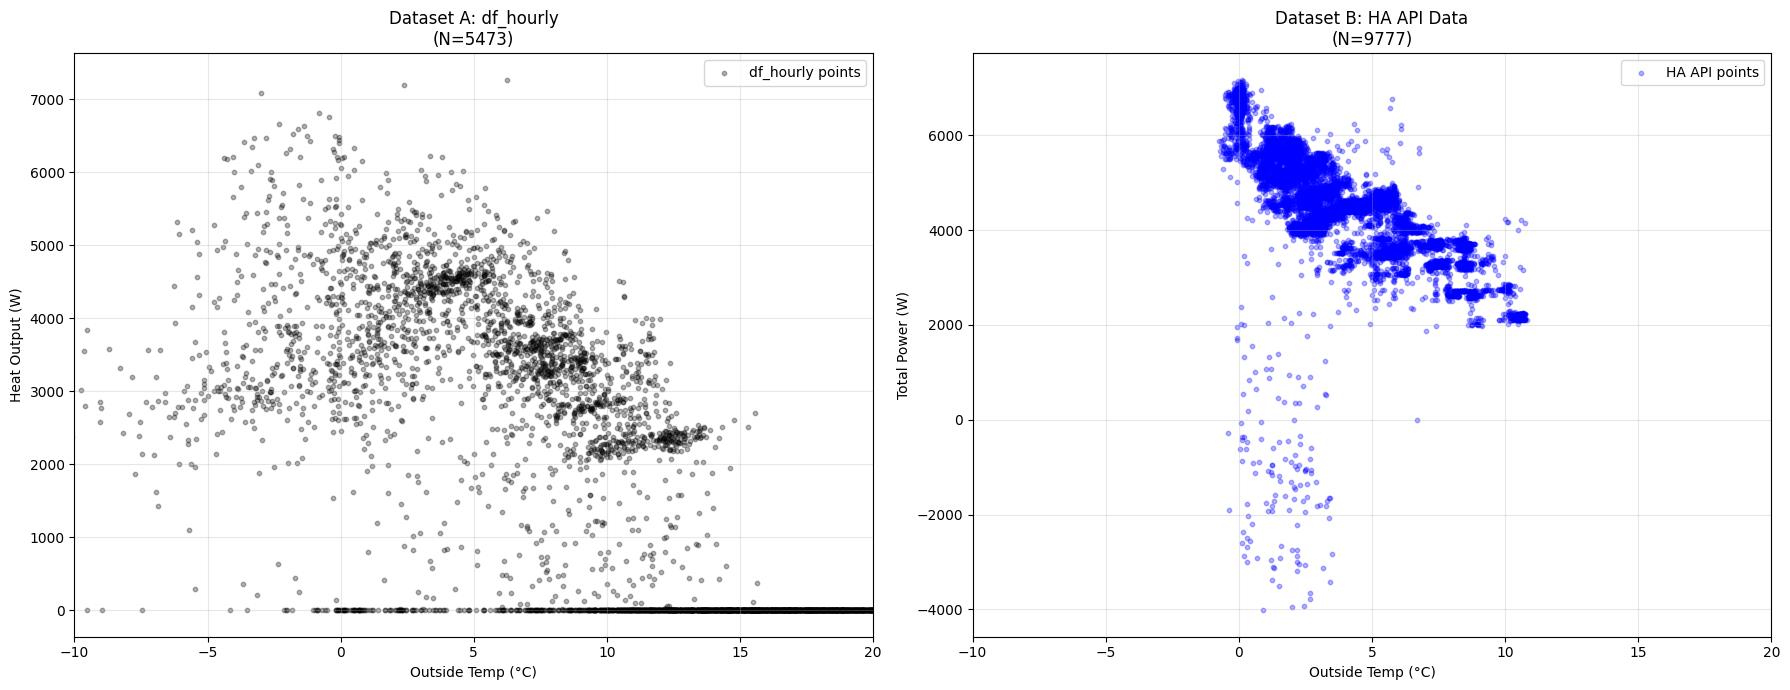


--- STEP 1: ROBUST KNEE DETECTION ---
KNEE DETECTED: -0.42 °C at 5929 W


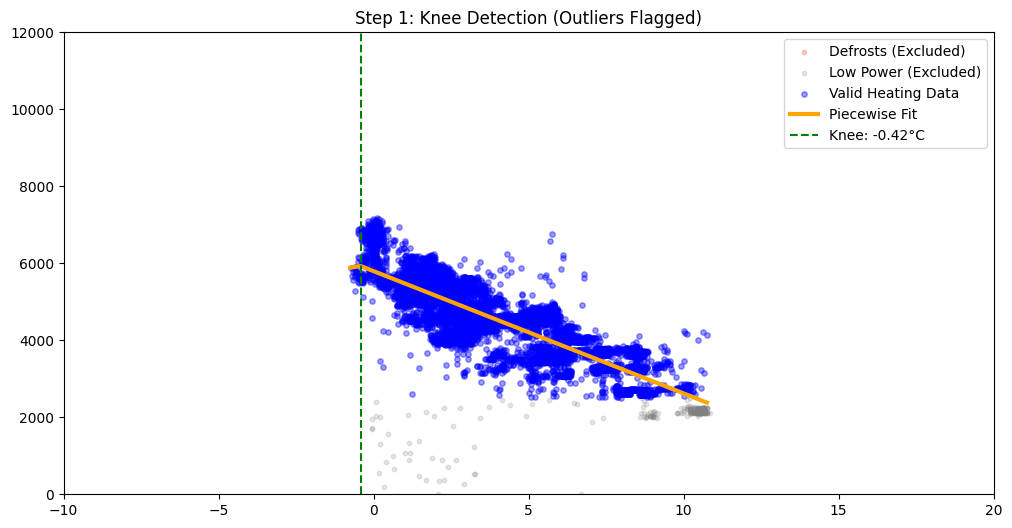


STEP 2: INSIGHTS DATA ANALYSIS (Left of Knee: < -0.42°C)
Data points left of knee: 377
Points removed by Pre-Envelope Outlier Detection: 7
Points removed by Max-Envelope Filter: 316
 (Kept hours where output was >90.0% of the max observed at that temp)


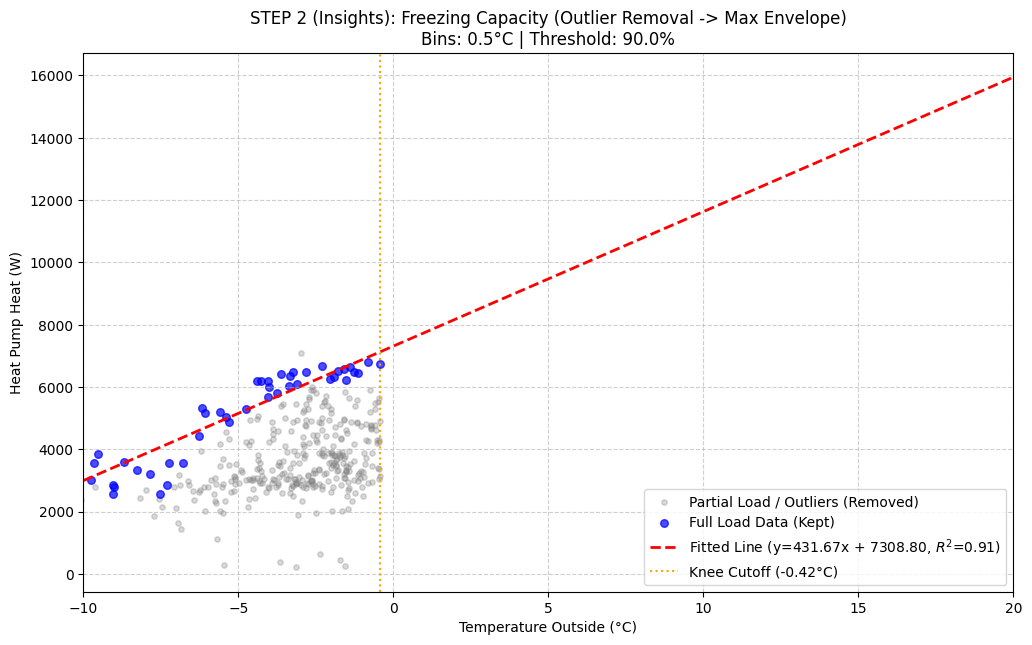

Local Equation: y = 431.67x + 7308.80 (R2: 0.909)


In [4]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.optimize import curve_fit
import gc

# ==============================================================================
# CONFIGURATION
# ==============================================================================

# List possible temperature entities in order of priority
ENTITY_TEMP_OPTIONS = [
    "sensor.heatpump_hp1_temperature_outside", 
    "sensor.heatpump_hp2_temperature_outside",
    "sensor.thermostat_temperature_outside"
]
ENTITY_POWER = "sensor.heatpump_total_power"

DAYS_HISTORY = 10
MIN_POWER_FILTER = 2500 
STD_DEV_THRESHOLD = 2.0 
DEFROST_THRESHOLD = 0

# Local Analysis Config (Max-Envelope)
BIN_SIZE = 0.5          # Group temps by 0.5 degrees
KEEP_THRESHOLD = 0.90   # Keep values >= 90% of max in bin

# Default fallback
dynamic_min_temp = -0.5 

# ==============================================================================
# PHASE 1: DATA FETCHING & PROCESSING (PRE-PLOT)
# ==============================================================================
print("\n" + "="*60)
print("PHASE 1: FETCHING AND PROCESSING DATA")
print("="*60)

# --- 1. Fetch HA Data ---
def get_raw_history():
    end_dt = datetime.now()
    start_dt = end_dt - timedelta(days=DAYS_HISTORY)
    
    # Combine all possible temp entities and the power entity for the filter
    all_entities = ENTITY_TEMP_OPTIONS + [ENTITY_POWER]
    filter_ids = ",".join(all_entities)
    
    url = f"{HA_URL}/api/history/period/{start_dt.isoformat()}"
    headers = {"Authorization": f"Bearer {TOKEN}", "content-type": "application/json"}
    params = {
        "end_time": end_dt.isoformat(),
        "filter_entity_id": filter_ids,
        "minimal_response": "false",
        "significant_changes_only": "0"
    }
    
    print(f"Fetching raw history for entities: {filter_ids}...")
    try:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f"API Error: {e}")
        return []

raw_json = get_raw_history()
df_temp_median = None
df_power_median = None
df_ha_merged = None

# --- 2. Process HA Data ---
if raw_json:
    raw_temp_list = []
    raw_power_list = []
    
    # We want to find the BEST available temp entity from our list
    # First, let's map what we actually got back from the API
    received_data = {entity_list[0]['entity_id']: entity_list for entity_list in raw_json if entity_list}
    
    # 1. Try to find the temperature data based on priority list
    active_temp_entity = None
    for temp_option in ENTITY_TEMP_OPTIONS:
        if temp_option in received_data:
            raw_temp_list = received_data[temp_option]
            active_temp_entity = temp_option
            print(f"Found temperature data via: {active_temp_entity}")
            break # Stop at the first one that has data
            
    # 2. Find the power data
    if ENTITY_POWER in received_data:
        raw_power_list = received_data[ENTITY_POWER]
    
    del received_data
    gc.collect()

    if raw_temp_list:
        df_t = pd.DataFrame(raw_temp_list)
        df_t['timestamp'] = pd.to_datetime(df_t['last_changed'], utc=True).dt.tz_convert(None).dt.floor('min')
        df_t['state'] = pd.to_numeric(df_t['state'], errors='coerce')
        df_t = df_t.dropna(subset=['state'])
        df_temp_median = df_t.groupby('timestamp')['state'].median().rename('temp')
        del df_t
        gc.collect()

    if raw_power_list:
        df_p = pd.DataFrame(raw_power_list)
        df_p['timestamp'] = pd.to_datetime(df_p['last_changed'], utc=True).dt.tz_convert(None).dt.floor('min')
        df_p['state'] = pd.to_numeric(df_p['state'], errors='coerce')
        df_p = df_p.dropna(subset=['state'])
        df_power_median = df_p.groupby('timestamp')['state'].median().rename('power')
        del df_p
        gc.collect()
        
    # Merge for HA Data
    if df_temp_median is not None and df_power_median is not None:
        df_ha_merged = pd.merge(df_temp_median, df_power_median, left_index=True, right_index=True, how='inner')
        print(f"HA Data Processed: {len(df_ha_merged)} aligned data points.")
    else:
        if not raw_temp_list:
            print("Error: No temperature data found for any of the provided entities.")
        if not raw_power_list:
            print(f"Error: No power data found for {ENTITY_POWER}.")
else:
    print("No data returned from API.")

# ==============================================================================
# PHASE 2: SIDE-BY-SIDE RAW DATA PLOT
# ==============================================================================
print("\n" + "="*60)
print("PHASE 2: SIDE-BY-SIDE COMPARISON (Raw Data)")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharex=True)

# --- PLOT 1: df_hourly (Insights) ---
ax1 = axes[0]
if 'df_hourly' in globals() and not df_hourly.empty:
    if 'temperatureOutside' in df_hourly.columns and 'hpHeat' in df_hourly.columns:
        ax1.scatter(df_hourly['temperatureOutside'], df_hourly['hpHeat'], 
                   alpha=0.3, s=10, c='black', label='df_hourly points')
        ax1.set_title(f'Dataset A: df_hourly\n(N={len(df_hourly)})')
        ax1.set_xlabel('Outside Temp (°C)')
        ax1.set_ylabel('Heat Output (W)') # Assuming hpHeat is thermal
        ax1.grid(True, alpha=0.3)
        ax1.legend()
    else:
        ax1.text(0.5, 0.5, "Columns missing in df_hourly", ha='center')
else:
    ax1.text(0.5, 0.5, "df_hourly not found", ha='center')

# --- PLOT 2: HA Data (Power) ---
ax2 = axes[1]
if df_ha_merged is not None and not df_ha_merged.empty:
    ax2.scatter(df_ha_merged['temp'], df_ha_merged['power'], 
               alpha=0.3, s=10, c='blue', label='HA API points')
    ax2.set_title(f'Dataset B: HA API Data\n(N={len(df_ha_merged)})')
    ax2.set_xlabel('Outside Temp (°C)')
    ax2.set_ylabel('Total Power (W)') # Electrical
    ax2.grid(True, alpha=0.3)
    ax2.legend()
else:
    ax2.text(0.5, 0.5, "HA Data not available", ha='center')

plt.xlim(-10, 20)
plt.tight_layout()
plt.show()

# ==============================================================================
# STEP 1: ROBUST KNEE DETECTION (PIECEWISE FIT)
# ==============================================================================
print("\n--- STEP 1: ROBUST KNEE DETECTION ---")

if df_ha_merged is not None and not df_ha_merged.empty:
    # 1. SEPARATE DATASET
    df_ha_merged['category'] = 'valid'
    df_ha_merged.loc[df_ha_merged['power'] < DEFROST_THRESHOLD, 'category'] = 'defrost'
    df_ha_merged.loc[(df_ha_merged['power'] >= DEFROST_THRESHOLD) & (df_ha_merged['power'] < MIN_POWER_FILTER), 'category'] = 'low_power'
    
    # 2. PREPARE DATA FOR FIT (Valid only)
    df_fit = df_ha_merged[df_ha_merged['category'] == 'valid'].copy()
    
    if not df_fit.empty:
        x_data = df_fit['temp'].values
        y_data = df_fit['power'].values

        def piecewise_linear(x, x0, y0, k1, k2):
            return np.where(x < x0, k1 * (x - x0) + y0, k2 * (x - x0) + y0)

        # 3. CONSTRAINED FIT
        p0 = [1.0, y_data.max(), 0, -400]
        lower_b = [-3, 3000, -500, -2000]
        upper_b = [ 4, 9000,  500, -100]

        try:
            popt, _ = curve_fit(piecewise_linear, x_data, y_data, p0=p0, bounds=(lower_b, upper_b))
            dynamic_min_temp, max_knee_power, k1, k2 = popt
            print(f"KNEE DETECTED: {dynamic_min_temp:.2f} °C at {max_knee_power:.0f} W")

            # 4. PLOT STEP 1
            plt.figure(figsize=(12, 6))
            plt.scatter(df_ha_merged[df_ha_merged['category']=='defrost']['temp'], df_ha_merged[df_ha_merged['category']=='defrost']['power'], color='red', alpha=0.2, s=10, label='Defrosts (Excluded)')
            plt.scatter(df_ha_merged[df_ha_merged['category']=='low_power']['temp'], df_ha_merged[df_ha_merged['category']=='low_power']['power'], color='gray', alpha=0.2, s=10, label='Low Power (Excluded)')
            plt.scatter(x_data, y_data, color='blue', alpha=0.4, s=15, label='Valid Heating Data')
            
            x_range = np.linspace(x_data.min(), x_data.max(), 200)
            plt.plot(x_range, piecewise_linear(x_range, *popt), color='orange', linewidth=3, label='Piecewise Fit')
            plt.axvline(dynamic_min_temp, color='green', linestyle='--', label=f'Knee: {dynamic_min_temp:.2f}°C')
            plt.title("Step 1: Knee Detection (Outliers Flagged)")
                # --- ADJUSTED AXES ---
            plt.xlim(-10, 20)
            plt.ylim(0, 12000)
            # ---------------------/
            
            plt.legend()
            plt.show()
            
            # Set variables for next steps
            df_final_api = df_fit[df_fit['temp'] >= dynamic_min_temp]
            if len(df_final_api) > 1:
                slope_api, intercept_api = np.polyfit(df_final_api['temp'], df_final_api['power'], 1)
        except Exception as e: 
            print(f"Fit failed: {e}")
    else:
        print("No valid heating data found for fitting.")


# ==============================================================================
# STEP 2: INSIGHTS DATAFRAME ANALYSIS (Max-Envelope Logic)
# ==============================================================================
print("\n" + "="*60)
print(f"STEP 2: INSIGHTS DATA ANALYSIS (Left of Knee: < {dynamic_min_temp:.2f}°C)")
print("="*60)

if 'df_hourly' in globals() and not df_hourly.empty:
    # 1. BASIC CLEANUP
    df_filtered = df_hourly[
        (df_hourly['hpHeat'] > 100) & 
        (df_hourly['temperatureOutside'] < dynamic_min_temp) &
        (df_hourly['temperatureOutside'].notna())
    ].copy()

    print(f"Data points left of knee: {len(df_filtered)}")

    if len(df_filtered) > 5:
        # ---------------------------------------------------------
        # 2. PRE-ENVELOPE OUTLIER DETECTION (Z-Score)
        # ---------------------------------------------------------
        # We do this BEFORE the envelope to ensure a single spike doesn't skew the "Max"
        x_rough = df_filtered['temperatureOutside']
        y_rough = df_filtered['hpHeat']
        
        # Fit a rough line
        m_rough, b_rough = np.polyfit(x_rough, y_rough, 1)
        resid_rough = y_rough - (m_rough * x_rough + b_rough)
        std_rough = np.std(resid_rough)
        
        # Remove extreme outliers (e.g., > 2.5 sigma)
        if std_rough > 0:
            mask_rough = np.abs(resid_rough) < (2.5 * std_rough)
            df_pre_clean = df_filtered[mask_rough].copy()
        else:
            df_pre_clean = df_filtered.copy()
            
        print(f"Points removed by Pre-Envelope Outlier Detection: {len(df_filtered) - len(df_pre_clean)}")

        # ---------------------------------------------------------
        # 3. MAX-ENVELOPE FILTER (Compensate for Cycling)
        # ---------------------------------------------------------
        # Create Temperature Bins
        df_pre_clean['temp_bin'] = (df_pre_clean['temperatureOutside'] / BIN_SIZE).round() * BIN_SIZE
        
        # Find the MAX wattage observed in each temperature bin (using cleaned data)
        df_pre_clean['max_in_bin'] = df_pre_clean.groupby('temp_bin')['hpHeat'].transform('max')
        
        # Filter: Keep rows that are close to that Max
        mask_envelope = df_pre_clean['hpHeat'] >= (df_pre_clean['max_in_bin'] * KEEP_THRESHOLD)
        df_envelope = df_pre_clean[mask_envelope].copy()
        
        print(f"Points removed by Max-Envelope Filter: {len(df_pre_clean) - len(df_envelope)}")
        print(f" (Kept hours where output was >{KEEP_THRESHOLD*100}% of the max observed at that temp)")

        # ---------------------------------------------------------
        # 4. FINAL FITTING
        # ---------------------------------------------------------
        x = df_envelope['temperatureOutside']
        y = df_envelope['hpHeat']
        
        if len(x) > 1:
            slope_local, intercept_local = np.polyfit(x, y, 1)
            
            # --- CALCULATE R2 ---
            y_pred_local = slope_local * x + intercept_local
            ss_res_local = np.sum((y - y_pred_local) ** 2)
            ss_tot_local = np.sum((y - np.mean(y)) ** 2)
            r2_local = 1 - (ss_res_local / ss_tot_local)
            # --------------------

            # Extrapolation
            x_line = np.linspace(-10, 20, 100)
            y_line = slope_local * x_line + intercept_local

            # 5. PLOTTING
            plt.figure(figsize=(12, 7))
            
            # Plot the "Partial Load" data (Gray)
            df_partial = df_filtered[~df_filtered.index.isin(df_envelope.index)]
            plt.scatter(df_partial['temperatureOutside'], df_partial['hpHeat'], 
                        color='gray', alpha=0.3, s=15, label='Partial Load / Outliers (Removed)')

            # Plot Valid Data (Blue)
            plt.scatter(x, y, color='blue', alpha=0.7, s=30, label='Full Load Data (Kept)')

            plt.plot(x_line, y_line, color='red', linewidth=2, linestyle='--', 
                     label=f'Fitted Line (y={slope_local:.2f}x + {intercept_local:.2f}, $R^2$={r2_local:.2f})')
            
            # Show cutoff line
            plt.axvline(dynamic_min_temp, color='orange', linestyle=':', label=f'Knee Cutoff ({dynamic_min_temp:.2f}°C)')

            plt.title(f'STEP 2 (Insights): Freezing Capacity (Outlier Removal -> Max Envelope)\nBins: {BIN_SIZE}°C | Threshold: {KEEP_THRESHOLD*100}%')
            plt.xlabel('Temperature Outside (°C)')
            plt.ylabel('Heat Pump Heat (W)')
            plt.xlim(-10, 20)
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.legend()
            plt.show()
            
            print(f"Local Equation: y = {slope_local:.2f}x + {intercept_local:.2f} (R2: {r2_local:.3f})")
        else:
            print("Local: Not enough clean data points to fit a line.")
    else:
        print("Local: Not enough data points below the knee temperature.")
else:
    print("Local Skipped: 'df_hourly' not found or empty.")

INTERSECTION POINTS
3. Freezing Performance Limit:   -3.57 °C
4. Freezing Performance Limit with backup:   -6.40 °C
5. Temp at which CiC asks full capacity (est. stooklijn vs est. actual perf): -2.02 °C
   (At this temp, system delivers 6437 W)
------------------------------------------------------------
ESTIMATED CURRENT STOOKLIJN
------------------------------------------------------------
Wattage at -10°C: 8972 W
Temperature at 0 W: 18.2 °C


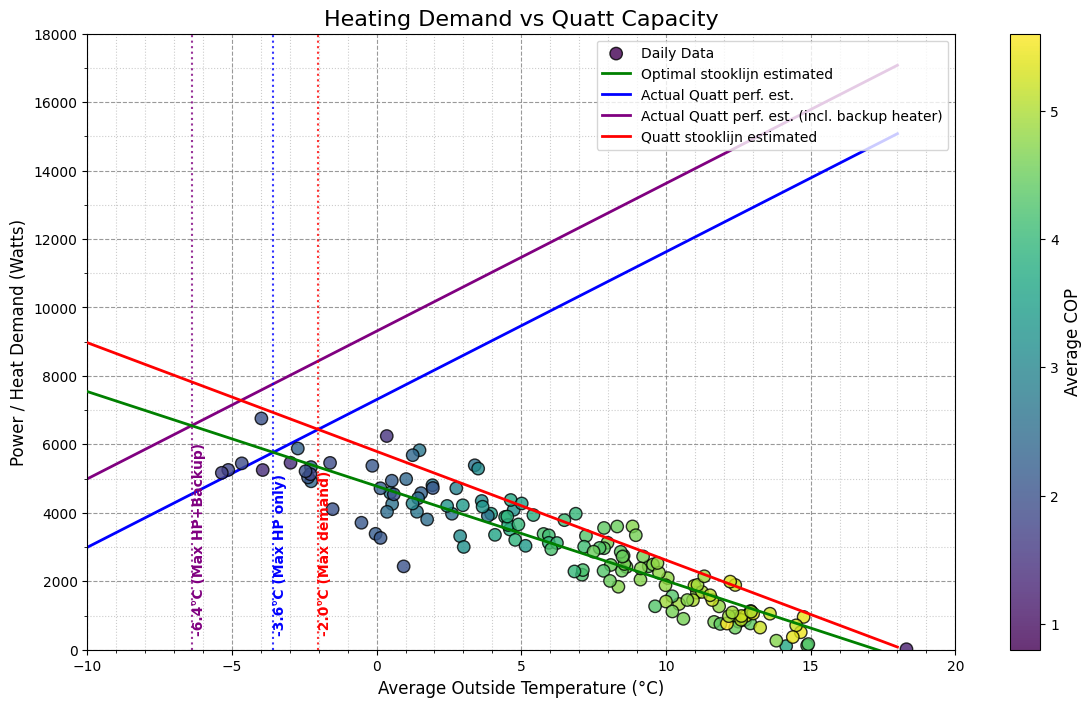

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from scipy.stats import linregress

# ==========================================
# 0. PLOT CONFIGURATION
# ==========================================
show_quatt_specs = False  # Set to True to show Quatt v1.5 DUO Nominal/Max lines

# Check if dataframe exists
if 'df_daily' in globals() and not df_daily.empty:
    
    # 1. PREPARE REAL DATA
    plot_data = df_daily[['avg_temperatureOutside', 'totalHeatPerHour', 'averageCOP']].copy()
    plot_data = plot_data.replace([np.inf, -np.inf], np.nan).dropna()

    if len(plot_data) >= 2:
        
        x = plot_data['avg_temperatureOutside']
        y = plot_data['totalHeatPerHour']
        colors = plot_data['averageCOP']
        
        # --- HOME HYBRID FIT (Usage) ---
        z_global = np.polyfit(x, y, 1)
        slope_global = z_global[0]
        intercept_global = z_global[1]
        
        # Calculate the fixed X-intercept (Temperature where heating is 0)
        if slope_global != 0:
            x_intercept_fixed = -intercept_global / slope_global
        else:
            x_intercept_fixed = 20 
            
        mask = (x >= -5) & (x <= 5)
        x_subset = x[mask]
        y_subset = y[mask]
        
        if len(x_subset) > 0:
            x_shifted = x_subset - x_intercept_fixed
            slope_special = np.dot(x_shifted, y_subset) / np.dot(x_shifted, x_shifted)
            intercept_special = -slope_special * x_intercept_fixed
            
            def special_trendline(val):
                return slope_special * (val - x_intercept_fixed)
        else:
            slope_special = slope_global
            intercept_special = intercept_global
            def special_trendline(val):
                return (slope_global * val) + intercept_global

        # --- QUATT REFERENCE DATA ---
        temps_ref = np.array([7, 2, -7])
        p_nom_duo_W = np.array([9.0, 7.4, 5.4]) * 1000
        p_max_duo_W = np.array([12.0, 10.4, 7.6]) * 1000

        slope_nom, intercept_nom, _, _, _ = linregress(temps_ref, p_nom_duo_W)
        slope_max, intercept_max, _, _, _ = linregress(temps_ref, p_max_duo_W)

        # ---------------------------------------------------------
        # ACTUAL QUATT PERF (FREEZING TEMPS) - FROM PART 1
        # ---------------------------------------------------------     
        if 'slope_local' in globals() and 'intercept_local' in globals():
            slope_freeze = slope_local
            intercept_freeze = intercept_local
            label_freeze = f"Actual Quatt perf. est."
            
            # Backup heater logic (adding 2000W)
            slope_freeze_backup_heater = slope_local
            intercept_freeze_backup_heater = intercept_local + 2000
            label_freeze_backup = f"Actual Quatt perf. est. (incl. backup heater)"
        else:
            # Fallback defaults if Part 1 didn't run
            slope_freeze = 167.40
            intercept_freeze = 8092.81
            label_freeze = "Quatt Perf. (Default)"
            slope_freeze_backup_heater = slope_freeze
            intercept_freeze_backup_heater = intercept_freeze + 2000
            label_freeze_backup = "Quatt Perf + Backup (Default)"

        # ==========================================
        # CALCULATE INTERSECTIONS
        # ==========================================
        
        # 1. Intersection with Nominal
        denom_nom = slope_special - slope_nom
        if denom_nom != 0:
            x_cross_nom = (intercept_nom - intercept_special) / denom_nom
        else:
            x_cross_nom = None

        # 2. Intersection with Max
        denom_max = slope_special - slope_max
        if denom_max != 0:
            x_cross_max = (intercept_max - intercept_special) / denom_max
        else:
            x_cross_max = None

        # 3. Intersection with Freezing Performance (Using Part 1 Data)
        denom_freeze = slope_special - slope_freeze
        if denom_freeze != 0:
            x_cross_freeze = (intercept_freeze - intercept_special) / denom_freeze
            y_cross_freeze = slope_special * x_cross_freeze + intercept_special
        else:
            x_cross_freeze = None

         # 4. Intersection with Freezing backup heater Performance (Using Part 1 Data)
        denom_freeze_backup = slope_special - slope_freeze_backup_heater
        if denom_freeze_backup != 0:
            x_cross_freeze_backup = (intercept_freeze_backup_heater - intercept_special) / denom_freeze_backup
            y_cross_backup = slope_special * x_cross_freeze_backup + intercept_special
        else:
            x_cross_freeze_backup = None

        # ==========================================
        # PLOTTING
        # ==========================================
        plt.figure(figsize=(14, 8))
        ax = plt.gca()
        
        # Scatter & Trendlines
        sc = plt.scatter(x, y, c=colors, cmap='viridis', s=80, alpha=0.8, edgecolors='black', zorder=3, label='Daily Data')
        cbar = plt.colorbar(sc)
        cbar.set_label('Average COP', fontsize=12)
        
        x_range = np.linspace(-12, 18, 100)
        
        # 1. Usage Line (Green Dashed)
        plt.plot(x_range, special_trendline(x_range), color='green', linestyle='-', linewidth=2, label='Optimal stooklijn estimated', zorder=4)

        # 2. Quatt Nominal/Max (CONDITIONAL)
        if show_quatt_specs:
            y_nom = slope_nom * x_range + intercept_nom
            y_max = slope_max * x_range + intercept_max
            plt.plot(x_range, y_nom, label='Quatt Nominal', color='cyan', linestyle='-.', alpha=0.8, zorder=2)
            plt.plot(x_range, y_max, label='Quatt Max', color='orange', linestyle='-.', alpha=0.8, zorder=2)

        # 3. Actual Quatt perf. (freezing temps) - FROM PART 1
        y_freeze = slope_freeze * x_range + intercept_freeze
        plt.plot(x_range, y_freeze, label=label_freeze, color='blue', linestyle='-', linewidth=2, alpha=1.0, zorder=2)

        # 4. Actual Quatt perf. backup heater (freezing temps) - FROM PART 1
        y_freeze_backup = slope_freeze_backup_heater * x_range + intercept_freeze_backup_heater
        plt.plot(x_range, y_freeze_backup, label=label_freeze_backup, color='Purple', linestyle='-', linewidth=2, alpha=1.0, zorder=2)

        # ---------------------------------------------------------
        # QUATT STOOKLIJN ESTIMATED - FROM PART 2
        # ---------------------------------------------------------
        x_cross_stook_freeze = None
        
        if 'slope_api' in globals() and 'intercept_api' in globals():
            # Calculate Y values
            y_line_stook = slope_api * x_range + intercept_api
            
            # Plot the line (Magenta)
            plt.plot(x_range, y_line_stook, color='red', linestyle='-', linewidth=2, label=f'Quatt stooklijn estimated', zorder=5)
            
            # ---------------------------------------------------------
            # NEW INTERSECTION: Stooklijn (Magenta) vs Actual Perf (Green Dotted)
            # ---------------------------------------------------------
            denom_stook_freeze = slope_api - slope_freeze
            if denom_stook_freeze != 0:
                x_cross_stook_freeze = (intercept_freeze - intercept_api) / denom_stook_freeze
                y_cross_stook_freeze = slope_api * x_cross_stook_freeze + intercept_api
        
        # --- PLOT INTERSECTIONS (CONDITIONAL) ---
        
        if show_quatt_specs:
            # Nominal Intersection
            if x_cross_nom is not None:
                plt.axvline(x_cross_nom, color='cyan', linestyle=':', alpha=0.5)
                plt.text(x_cross_nom, 500, f"{x_cross_nom:.1f}°C (Max Nom)", color='cyan', fontweight='bold', ha='right', rotation=90)

            # Max Intersection
            if x_cross_max is not None:
                plt.axvline(x_cross_max, color='orange', linestyle=':', alpha=0.5)
                plt.text(x_cross_max, 500, f"{x_cross_max:.1f}°C (Max spec)", color='orange', fontweight='bold', ha='right', rotation=90)

        # Freezing Intersection (Always show this as it relates to Part 1 vs Usage)
        if x_cross_freeze is not None:
            plt.axvline(x_cross_freeze, color='blue', linestyle=':', alpha=0.8)
            plt.text(x_cross_freeze, 500, f"{x_cross_freeze:.1f}°C (Max HP only)", color='blue', fontweight='bold', ha='left', rotation=90)

        if x_cross_stook_freeze is not None:
            plt.axvline(x_cross_stook_freeze, color='red', linestyle=':', alpha=0.8)
            plt.text(x_cross_stook_freeze, 500, f"{x_cross_stook_freeze:.1f}°C (Max demand)", color='red', fontweight='bold', ha='left', rotation=90)

        # Freezing Intersection (Always show this as it relates to Part 1 vs Usage)
        if x_cross_freeze_backup is not None:
            plt.axvline(x_cross_freeze_backup, color='purple', linestyle=':', alpha=0.8)
            plt.text(x_cross_freeze_backup, 500, f"{x_cross_freeze_backup:.1f}°C (Max HP+Backup)", color='purple', fontweight='bold', ha='left', rotation=90)
            
        # Formatting
        plt.title('Heating Demand vs Quatt Capacity', fontsize=16)
        plt.xlabel('Average Outside Temperature (°C)', fontsize=12)
        plt.ylabel('Power / Heat Demand (Watts)', fontsize=12)
        
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(1000))
        plt.grid(True, which='major', linestyle='--', alpha=0.8, color='gray')
        plt.grid(True, which='minor', linestyle=':', alpha=0.4, color='gray')
        plt.xlim(left=-10, right=20)
        plt.ylim(bottom=0, top=18000)
        plt.legend(loc='upper right')

        # --- PRINT RESULTS ---
        print("=" * 60)
        print(f"INTERSECTION POINTS")
        print("=" * 60)
        
        if show_quatt_specs:
            if x_cross_nom:
                print(f"1. NOMINAL capacity reached at:  {x_cross_nom:.2f} °C")
            
            if x_cross_max:
                print(f"2. MAX spec capacity reached at:      {x_cross_max:.2f} °C")

        if x_cross_freeze:
            print(f"3. Freezing Performance Limit:   {x_cross_freeze:.2f} °C")
        if x_cross_freeze_backup:
            print(f"4. Freezing Performance Limit with backup:   {x_cross_freeze_backup:.2f} °C")
        if x_cross_stook_freeze:
            print(f"5. Temp at which CiC asks full capacity (est. stooklijn vs est. actual perf): {x_cross_stook_freeze:.2f} °C")
            print(f"   (At this temp, system delivers {y_cross_stook_freeze:.0f} W)")

        # --- NEW: ESTIMATED CURRENT STOOKLIJN METRICS ---
        if 'slope_api' in globals() and 'intercept_api' in globals():
            print("-" * 60)
            print("ESTIMATED CURRENT STOOKLIJN")
            print("-" * 60)
            
            # Calculate Wattage at -10C
            watt_at_minus_10 = slope_api * -10 + intercept_api
            print(f"Wattage at -10°C: {watt_at_minus_10:.0f} W")
            
            # Calculate Temp where Wattage is 0 (x-intercept)
            # 0 = mx + b  ->  x = -b / m
            if slope_api != 0:
                temp_at_zero = -intercept_api / slope_api
                print(f"Temperature at 0 W: {temp_at_zero:.1f} °C")
            else:
                print("Temperature at 0 W: Undefined (Slope is 0)")
            
        print("=" * 60)
        
        plt.show()
        
    else:
        print("Not enough valid data points to plot.")
else:
    print("Dataframe 'df_daily' not found.")

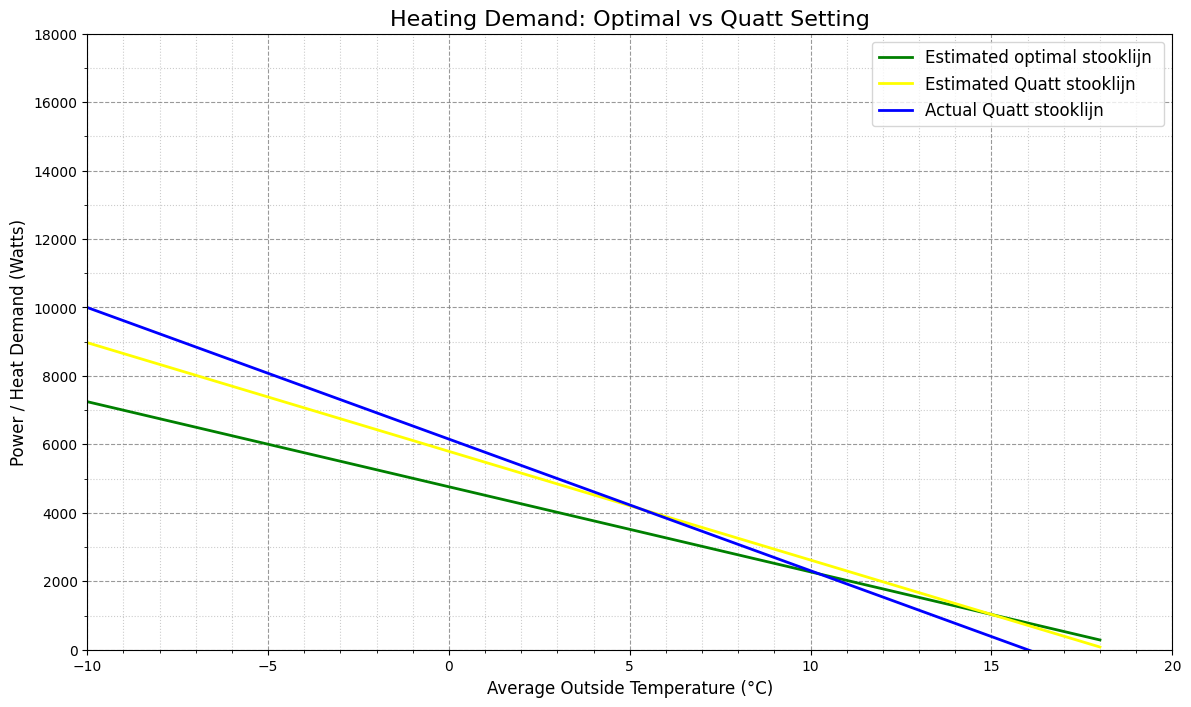

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

# Check if dataframe exists
if 'df_daily' in globals() and not df_daily.empty:
    
    # 1. PREPARE REAL DATA (Needed for "Optimal" line)
    plot_data = df_daily[['avg_temperatureOutside', 'totalHeatPerHour']].copy()
    plot_data = plot_data.replace([np.inf, -np.inf], np.nan).dropna()

    if len(plot_data) >= 2:
        
        x = plot_data['avg_temperatureOutside']
        y = plot_data['totalHeatPerHour']
        
        # --- CALCULATE OPTIMAL STOOKLIJN (Green Line) ---
        # Global fit to determine intercept
        z_global = np.polyfit(x, y, 1)
        slope_global = z_global[0]
        intercept_global = z_global[1]
        
        # Calculate the fixed X-intercept (Temperature where heating is 0)
        if slope_global != 0:
            x_intercept_fixed = -intercept_global / slope_global
        else:
            x_intercept_fixed = 20 
            
        # Refine slope based on heating season data (-5 to 5 degrees)
        mask = (x >= -5) & (x <= 5)
        x_subset = x[mask]
        y_subset = y[mask]
        
        if len(x_subset) > 0:
            x_shifted = x_subset - x_intercept_fixed
            slope_special = np.dot(x_shifted, y_subset) / np.dot(x_shifted, x_shifted)
            intercept_special = -slope_special * x_intercept_fixed
            
            def special_trendline(val):
                return slope_special * (val - x_intercept_fixed)
        else:
            slope_special = slope_global
            intercept_special = intercept_global
            def special_trendline(val):
                return (slope_global * val) + intercept_global

        # ==========================================
        # PLOTTING
        # ==========================================
        plt.figure(figsize=(14, 8))
        ax = plt.gca()
        
        x_range = np.linspace(-12, 18, 100)
        
        # 1. Optimal stooklijn estimated (Green)
        plt.plot(x_range, special_trendline(x_range), color='green', linestyle='-', linewidth=2, label='Estimated optimal stooklijn ')

        # 2. Quatt stooklijn estimated (Red)
        if 'slope_api' in globals() and 'intercept_api' in globals():
            y_line_stook = slope_api * x_range + intercept_api
            plt.plot(x_range, y_line_stook, color='yellow', linestyle='-', linewidth=2, label='Estimated Quatt stooklijn ')

        # 3. Actual Quatt stooklijn (Blue)
        # Points: (-10, 16600) and (13, 0)
        x1, y1 = -10, 10000
        x2, y2 = 16, 0
        
        # Calculate slope (m) and intercept (b)
        slope_actual = (y2 - y1) / (x2 - x1)
        intercept_actual = y1 - (slope_actual * x1)
        
        # Calculate Y values for the plot range
        y_actual_line = slope_actual * x_range + intercept_actual
        
        plt.plot(x_range, y_actual_line, color='blue', linestyle='-', linewidth=2, label='Actual Quatt stooklijn')

        # Formatting
        plt.title('Heating Demand: Optimal vs Quatt Setting', fontsize=16)
        plt.xlabel('Average Outside Temperature (°C)', fontsize=12)
        plt.ylabel('Power / Heat Demand (Watts)', fontsize=12)
        
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(1000))
        plt.grid(True, which='major', linestyle='--', alpha=0.8, color='gray')
        plt.grid(True, which='minor', linestyle=':', alpha=0.4, color='gray')
        plt.xlim(left=-10, right=20)
        plt.ylim(bottom=0, top=18000)
        plt.legend(loc='upper right', fontsize=12)
        
        plt.show()
        
    else:
        print("Not enough valid data points to plot.")
else:
    print("Dataframe 'df_daily' not found.")

INTERSECTION POINTS
3. Freezing Performance Limit:   -3.75 °C
4. Freezing Performance Limit with backup:   -6.68 °C
5. Temp at which CiC asks full capacity (est. stooklijn vs est. actual perf): -2.02 °C
   (At this temp, system delivers 6437 W)
------------------------------------------------------------
ESTIMATED CURRENT STOOKLIJN
------------------------------------------------------------
Wattage at -10°C: 8972 W
Temperature at 0 W: 18.2 °C


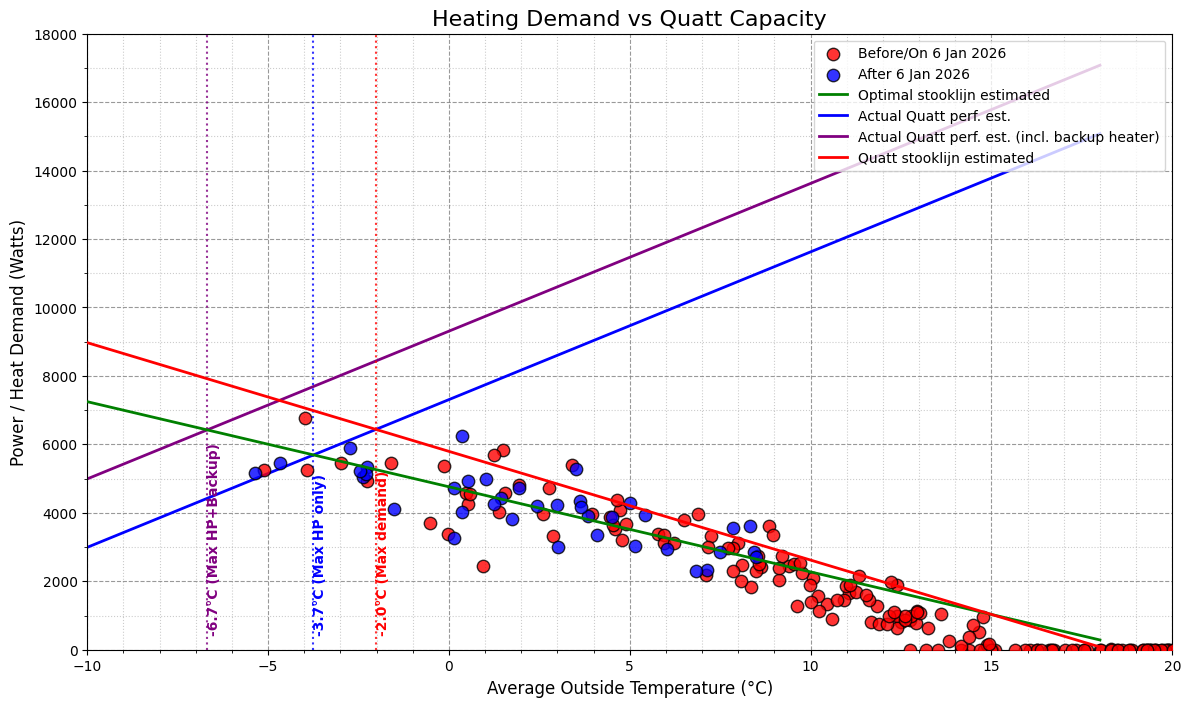

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from scipy.stats import linregress

# ==========================================
# 0. PLOT CONFIGURATION
# ==========================================
show_quatt_specs = False  # Set to True to show Quatt v1.5 DUO Nominal/Max lines

# Check if dataframe exists
if 'df_daily' in globals() and not df_daily.empty:
    
    # 1. PREPARE REAL DATA
    # We no longer strictly need averageCOP for coloring, but we keep the structure
    plot_data = df_daily[['avg_temperatureOutside', 'totalHeatPerHour']].copy()
    plot_data = plot_data.replace([np.inf, -np.inf], np.nan).dropna()

    # Ensure the index is in datetime format for comparison
    plot_data.index = pd.to_datetime(plot_data.index)

    if len(plot_data) >= 2:
        
        x = plot_data['avg_temperatureOutside']
        y = plot_data['totalHeatPerHour']
        
        # --- DATE BASED COLORING SETUP ---
        cutoff_date = pd.Timestamp('2026-01-06')
        
        # Create masks for the two groups
        mask_before = plot_data.index <= cutoff_date
        mask_after = plot_data.index > cutoff_date
        
        # --- HOME HYBRID FIT (Usage) ---
        # We still calculate the trendline based on ALL data (x, y)
        z_global = np.polyfit(x, y, 1)
        slope_global = z_global[0]
        intercept_global = z_global[1]
        
        # Calculate the fixed X-intercept (Temperature where heating is 0)
        if slope_global != 0:
            x_intercept_fixed = -intercept_global / slope_global
        else:
            x_intercept_fixed = 20 
            
        mask = (x >= -5) & (x <= 5)
        x_subset = x[mask]
        y_subset = y[mask]
        
        if len(x_subset) > 0:
            x_shifted = x_subset - x_intercept_fixed
            slope_special = np.dot(x_shifted, y_subset) / np.dot(x_shifted, x_shifted)
            intercept_special = -slope_special * x_intercept_fixed
            
            def special_trendline(val):
                return slope_special * (val - x_intercept_fixed)
        else:
            slope_special = slope_global
            intercept_special = intercept_global
            def special_trendline(val):
                return (slope_global * val) + intercept_global

        # --- QUATT REFERENCE DATA ---
        temps_ref = np.array([7, 2, -7])
        p_nom_duo_W = np.array([9.0, 7.4, 5.4]) * 1000
        p_max_duo_W = np.array([12.0, 10.4, 7.6]) * 1000

        slope_nom, intercept_nom, _, _, _ = linregress(temps_ref, p_nom_duo_W)
        slope_max, intercept_max, _, _, _ = linregress(temps_ref, p_max_duo_W)

        # ---------------------------------------------------------
        # ACTUAL QUATT PERF (FREEZING TEMPS) - FROM PART 1
        # ---------------------------------------------------------     
        if 'slope_local' in globals() and 'intercept_local' in globals():
            slope_freeze = slope_local
            intercept_freeze = intercept_local
            label_freeze = f"Actual Quatt perf. est."
            
            # Backup heater logic (adding 2000W)
            slope_freeze_backup_heater = slope_local
            intercept_freeze_backup_heater = intercept_local + 2000
            label_freeze_backup = f"Actual Quatt perf. est. (incl. backup heater)"
        else:
            # Fallback defaults if Part 1 didn't run
            slope_freeze = 167.40
            intercept_freeze = 8092.81
            label_freeze = "Quatt Perf. (Default)"
            slope_freeze_backup_heater = slope_freeze
            intercept_freeze_backup_heater = intercept_freeze + 2000
            label_freeze_backup = "Quatt Perf + Backup (Default)"

        # ==========================================
        # CALCULATE INTERSECTIONS
        # ==========================================
        
        # 1. Intersection with Nominal
        denom_nom = slope_special - slope_nom
        if denom_nom != 0:
            x_cross_nom = (intercept_nom - intercept_special) / denom_nom
        else:
            x_cross_nom = None

        # 2. Intersection with Max
        denom_max = slope_special - slope_max
        if denom_max != 0:
            x_cross_max = (intercept_max - intercept_special) / denom_max
        else:
            x_cross_max = None

        # 3. Intersection with Freezing Performance (Using Part 1 Data)
        denom_freeze = slope_special - slope_freeze
        if denom_freeze != 0:
            x_cross_freeze = (intercept_freeze - intercept_special) / denom_freeze
            y_cross_freeze = slope_special * x_cross_freeze + intercept_special
        else:
            x_cross_freeze = None

         # 4. Intersection with Freezing backup heater Performance (Using Part 1 Data)
        denom_freeze_backup = slope_special - slope_freeze_backup_heater
        if denom_freeze_backup != 0:
            x_cross_freeze_backup = (intercept_freeze_backup_heater - intercept_special) / denom_freeze_backup
            y_cross_backup = slope_special * x_cross_freeze_backup + intercept_special
        else:
            x_cross_freeze_backup = None

        # ==========================================
        # PLOTTING
        # ==========================================
        plt.figure(figsize=(14, 8))
        ax = plt.gca()
        
        # --- MODIFIED SCATTER PLOTS ---
        # Plot data <= Jan 6th (RED)
        plt.scatter(x[mask_before], y[mask_before], 
                    color='red', s=80, alpha=0.8, edgecolors='black', zorder=3, 
                    label='Before/On 6 Jan 2026')
        
        # Plot data > Jan 6th (BLUE)
        plt.scatter(x[mask_after], y[mask_after], 
                    color='blue', s=80, alpha=0.8, edgecolors='black', zorder=3, 
                    label='After 6 Jan 2026')
        
        # (Removed Colorbar as it is no longer COP based)
        
        x_range = np.linspace(-12, 18, 100)
        
        # 1. Usage Line (Green Dashed)
        plt.plot(x_range, special_trendline(x_range), color='green', linestyle='-', linewidth=2, label='Optimal stooklijn estimated', zorder=4)

        # 2. Quatt Nominal/Max (CONDITIONAL)
        if show_quatt_specs:
            y_nom = slope_nom * x_range + intercept_nom
            y_max = slope_max * x_range + intercept_max
            plt.plot(x_range, y_nom, label='Quatt Nominal', color='cyan', linestyle='-.', alpha=0.8, zorder=2)
            plt.plot(x_range, y_max, label='Quatt Max', color='orange', linestyle='-.', alpha=0.8, zorder=2)

        # 3. Actual Quatt perf. (freezing temps) - FROM PART 1
        y_freeze = slope_freeze * x_range + intercept_freeze
        plt.plot(x_range, y_freeze, label=label_freeze, color='blue', linestyle='-', linewidth=2, alpha=1.0, zorder=2)

        # 4. Actual Quatt perf. backup heater (freezing temps) - FROM PART 1
        y_freeze_backup = slope_freeze_backup_heater * x_range + intercept_freeze_backup_heater
        plt.plot(x_range, y_freeze_backup, label=label_freeze_backup, color='Purple', linestyle='-', linewidth=2, alpha=1.0, zorder=2)

        # ---------------------------------------------------------
        # QUATT STOOKLIJN ESTIMATED - FROM PART 2
        # ---------------------------------------------------------
        x_cross_stook_freeze = None
        
        if 'slope_api' in globals() and 'intercept_api' in globals():
            # Calculate Y values
            y_line_stook = slope_api * x_range + intercept_api
            
            # Plot the line (Magenta)
            plt.plot(x_range, y_line_stook, color='red', linestyle='-', linewidth=2, label=f'Quatt stooklijn estimated', zorder=5)
            
            # ---------------------------------------------------------
            # NEW INTERSECTION: Stooklijn (Magenta) vs Actual Perf (Green Dotted)
            # ---------------------------------------------------------
            denom_stook_freeze = slope_api - slope_freeze
            if denom_stook_freeze != 0:
                x_cross_stook_freeze = (intercept_freeze - intercept_api) / denom_stook_freeze
                y_cross_stook_freeze = slope_api * x_cross_stook_freeze + intercept_api
        
        # --- PLOT INTERSECTIONS (CONDITIONAL) ---
        
        if show_quatt_specs:
            # Nominal Intersection
            if x_cross_nom is not None:
                plt.axvline(x_cross_nom, color='cyan', linestyle=':', alpha=0.5)
                plt.text(x_cross_nom, 500, f"{x_cross_nom:.1f}°C (Max Nom)", color='cyan', fontweight='bold', ha='right', rotation=90)

            # Max Intersection
            if x_cross_max is not None:
                plt.axvline(x_cross_max, color='orange', linestyle=':', alpha=0.5)
                plt.text(x_cross_max, 500, f"{x_cross_max:.1f}°C (Max spec)", color='orange', fontweight='bold', ha='right', rotation=90)

        # Freezing Intersection (Always show this as it relates to Part 1 vs Usage)
        if x_cross_freeze is not None:
            plt.axvline(x_cross_freeze, color='blue', linestyle=':', alpha=0.8)
            plt.text(x_cross_freeze, 500, f"{x_cross_freeze:.1f}°C (Max HP only)", color='blue', fontweight='bold', ha='left', rotation=90)

        if x_cross_stook_freeze is not None:
            plt.axvline(x_cross_stook_freeze, color='red', linestyle=':', alpha=0.8)
            plt.text(x_cross_stook_freeze, 500, f"{x_cross_stook_freeze:.1f}°C (Max demand)", color='red', fontweight='bold', ha='left', rotation=90)

        # Freezing Intersection (Always show this as it relates to Part 1 vs Usage)
        if x_cross_freeze_backup is not None:
            plt.axvline(x_cross_freeze_backup, color='purple', linestyle=':', alpha=0.8)
            plt.text(x_cross_freeze_backup, 500, f"{x_cross_freeze_backup:.1f}°C (Max HP+Backup)", color='purple', fontweight='bold', ha='left', rotation=90)
            
        # Formatting
        plt.title('Heating Demand vs Quatt Capacity', fontsize=16)
        plt.xlabel('Average Outside Temperature (°C)', fontsize=12)
        plt.ylabel('Power / Heat Demand (Watts)', fontsize=12)
        
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(1000))
        plt.grid(True, which='major', linestyle='--', alpha=0.8, color='gray')
        plt.grid(True, which='minor', linestyle=':', alpha=0.4, color='gray')
        plt.xlim(left=-10, right=20)
        plt.ylim(bottom=0, top=18000)
        plt.legend(loc='upper right')

        # --- PRINT RESULTS ---
        print("=" * 60)
        print(f"INTERSECTION POINTS")
        print("=" * 60)
        
        if show_quatt_specs:
            if x_cross_nom:
                print(f"1. NOMINAL capacity reached at:  {x_cross_nom:.2f} °C")
            
            if x_cross_max:
                print(f"2. MAX spec capacity reached at:      {x_cross_max:.2f} °C")

        if x_cross_freeze:
            print(f"3. Freezing Performance Limit:   {x_cross_freeze:.2f} °C")
        if x_cross_freeze_backup:
            print(f"4. Freezing Performance Limit with backup:   {x_cross_freeze_backup:.2f} °C")
        if x_cross_stook_freeze:
            print(f"5. Temp at which CiC asks full capacity (est. stooklijn vs est. actual perf): {x_cross_stook_freeze:.2f} °C")
            print(f"   (At this temp, system delivers {y_cross_stook_freeze:.0f} W)")

        # --- NEW: ESTIMATED CURRENT STOOKLIJN METRICS ---
        if 'slope_api' in globals() and 'intercept_api' in globals():
            print("-" * 60)
            print("ESTIMATED CURRENT STOOKLIJN")
            print("-" * 60)
            
            # Calculate Wattage at -10C
            watt_at_minus_10 = slope_api * -10 + intercept_api
            print(f"Wattage at -10°C: {watt_at_minus_10:.0f} W")
            
            # Calculate Temp where Wattage is 0 (x-intercept)
            # 0 = mx + b  ->  x = -b / m
            if slope_api != 0:
                temp_at_zero = -intercept_api / slope_api
                print(f"Temperature at 0 W: {temp_at_zero:.1f} °C")
            else:
                print("Temperature at 0 W: Undefined (Slope is 0)")
            
        print("=" * 60)
        
        plt.show()
        
    else:
        print("Not enough valid data points to plot.")
else:
    print("Dataframe 'df_daily' not found.")

Data points remaining after cleaning: 2140

       REGRESSION ANALYSIS (Temp > 0°C)
Period: Before 07-01-2026
  Equation: COP = 0.2369 * T + 2.6048
  R²:       0.8801
----------------------------------------
Period: From 07-01-2026
  Equation: COP = 0.2522 * T + 2.4670
  R²:       0.8113
----------------------------------------


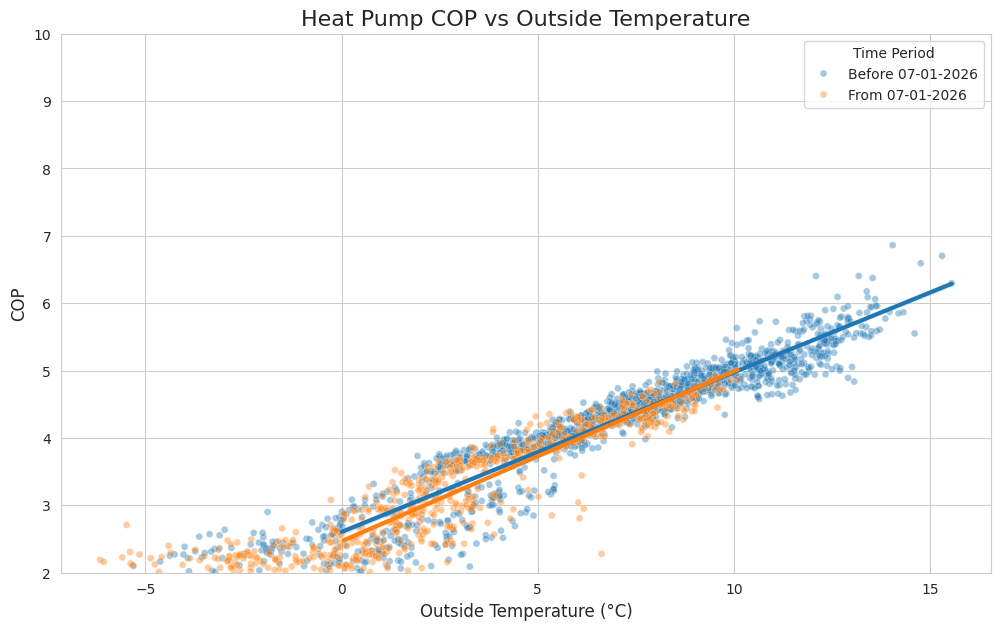

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# 1. Load Data
if 'df_hourly' in globals():
    df_plot = df_hourly.copy()
else:
    try:
        df_plot = pd.read_csv("quatt_hourly.csv")
        df_plot['timestamp'] = pd.to_datetime(df_plot['timestamp'])
        df_plot = df_plot.set_index('timestamp')
    except FileNotFoundError:
        print("Error: Data not found.")

# Fix Timezone
if df_plot.index.tz is not None:
    df_plot.index = df_plot.index.tz_localize(None)

# 2. Basic Prep
df_plot = df_plot[df_plot['hpElectric'] > 300].copy()
df_plot['COP'] = df_plot['hpHeat'] / df_plot['hpElectric']
df_plot = df_plot[(df_plot['COP'] >= 2) & (df_plot['COP'] <= 10)]

# =========================================================
# 3. ADVANCED OUTLIER REMOVAL (Quantile Filtering per Temp)
# =========================================================
# Round temperature to create bins
df_plot['temp_bin'] = df_plot['temperatureOutside'].round()

# Calculate dynamic limits (10th and 90th percentile) per temperature bin
#low_limit = df_plot.groupby('temp_bin')['COP'].transform(lambda x: x.quantile(0.10))
#high_limit = df_plot.groupby('temp_bin')['COP'].transform(lambda x: x.quantile(0.90))

# Filter data
df_plot = df_plot[(df_plot['COP'] >= 2) & (df_plot['COP'] <= 9)]

print(f"Data points remaining after cleaning: {len(df_plot)}")

# 4. Split Data
split_date = pd.Timestamp("2026-01-07")
df_plot['Period'] = df_plot.index.map(lambda t: "Before 07-01-2026" if t < split_date else "From 07-01-2026")

# 5. Plotting & Calculation
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

periods = ["Before 07-01-2026", "From 07-01-2026"]
palette = sns.color_palette("tab10", n_colors=2)
color_map = dict(zip(periods, palette))

# A. Scatter Plot
sns.scatterplot(
    data=df_plot,
    x="temperatureOutside",
    y="COP",
    hue="Period",
    hue_order=periods,
    palette=color_map,
    alpha=0.4,
    s=25
)

print("\n" + "="*40)
print("       REGRESSION ANALYSIS (Temp > 0°C)")
print("="*40)

# B. Regression Lines & Stats
for period in periods:
    # Filter: Specific Period AND Temp > 0
    subset = df_plot[(df_plot['Period'] == period) & (df_plot['temperatureOutside'] > 0)]
    
    if len(subset) > 5:
        # --- CALCULATE STATS ---
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            subset['temperatureOutside'], subset['COP']
        )
        r_squared = r_value**2
        
        # Print Stats
        print(f"Period: {period}")
        print(f"  Equation: COP = {slope:.4f} * T + {intercept:.4f}")
        print(f"  R²:       {r_squared:.4f}")
        print("-" * 40)

        # Draw Line
        sns.regplot(
            data=subset,
            x="temperatureOutside",
            y="COP",
            scatter=False,
            color=color_map[period],
            truncate=True,
            line_kws={'linewidth': 3}
        )

# 6. Formatting
plt.title("Heat Pump COP vs Outside Temperature", fontsize=16)
plt.xlabel("Outside Temperature (°C)", fontsize=12)
plt.ylabel("COP", fontsize=12)
plt.ylim(2, 10)
plt.yticks(np.arange(2, 11, 1))
plt.xlim(df_plot['temperatureOutside'].min() - 1, df_plot['temperatureOutside'].max() + 1)
plt.legend(title="Time Period")

plt.show()

HOUSE HEAT LOSS ANALYSIS

📊 Available data sources:
   ✅ Heat Pump data


HEAT PUMP HEAT LOSS ANALYSIS

📊 HEAT LOSS CHARACTERISTICS
----------------------------------------------------------------------
Heat Loss Equation: Heat (W) = -234.02 × T_outside + 4480.44
R² (fit quality):   0.8753

Heat Loss Coefficient:  234.02 W/K
  (House loses 234 watts for every degree temperature drop)

Balance Point Temperature: 19.1°C
  (No heating needed above this temperature)

📈 HEAT LOSS AT DIFFERENT TEMPERATURES
----------------------------------------------------------------------
At -10°C:   6821 W/hour  →  163.7 kWh/day
At  -5°C:   5651 W/hour  →  135.6 kWh/day
At   0°C:   4480 W/hour  →  107.5 kWh/day
At   5°C:   3310 W/hour  →   79.4 kWh/day
At  10°C:   2140 W/hour  →   51.4 kWh/day
At  15°C:    970 W/hour  →   23.3 kWh/day

🏠 THEORETICAL HEAT LOSS (assuming 20.0°C indoor temperature)
----------------------------------------------------------------------
Estimated U-value (overall): 234.02 W/

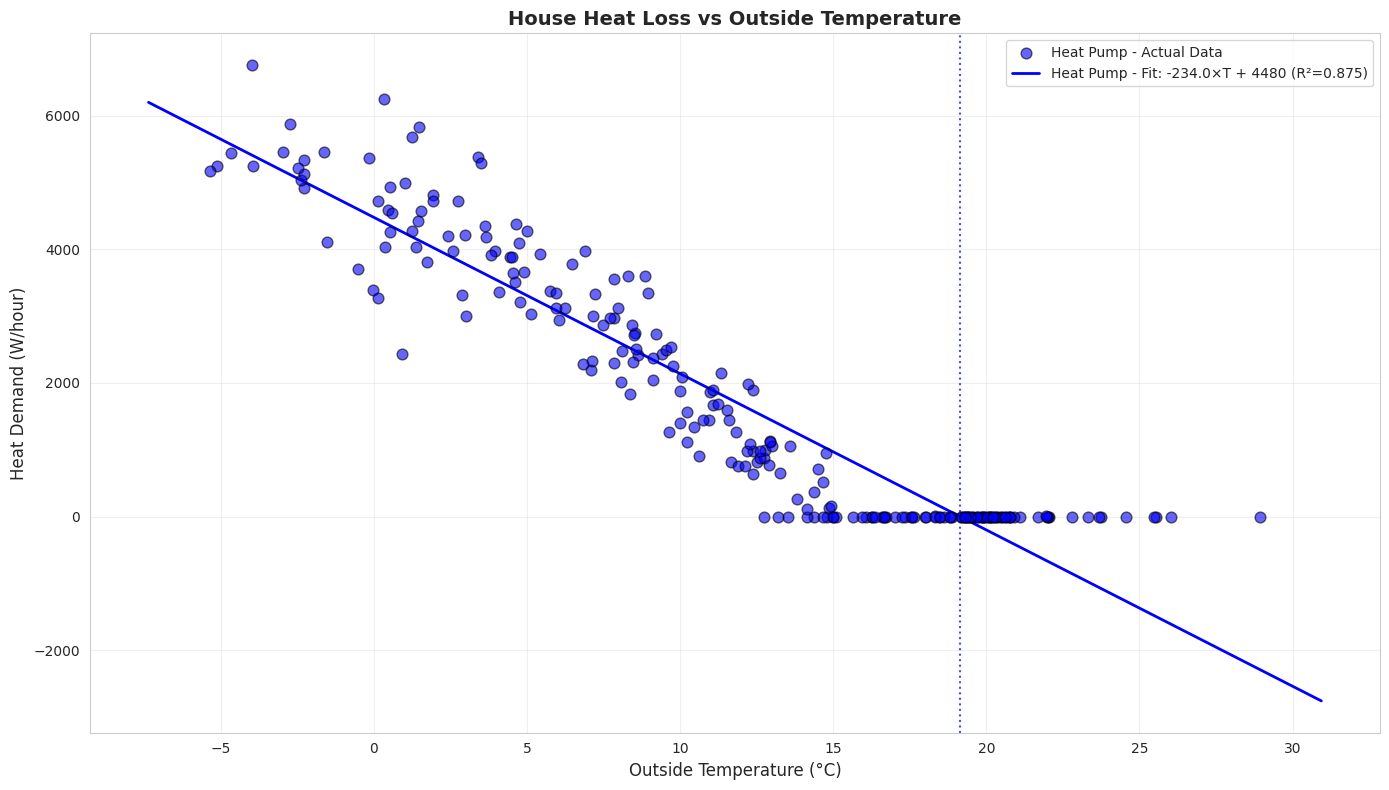

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ==========================================
# HOUSE HEAT LOSS ANALYSIS
# ==========================================

print("=" * 70)
print("HOUSE HEAT LOSS ANALYSIS")
print("=" * 70)

# Detect available data sources
has_heatpump = 'df_daily' in globals() and not df_daily.empty
has_gas = 'df_gas_daily' in globals() and not df_gas_daily.empty

if not has_heatpump and not has_gas:
    print("❌ No data available for heat loss analysis")
    print("   Please run Cell 2 (heat pump) or Cell 2B (gas consumption) first")
else:
    print(f"\n📊 Available data sources:")
    if has_heatpump:
        print("   ✅ Heat Pump data")
    if has_gas:
        print("   ✅ Gas consumption data")
    print()

# ==========================================
# ANALYSIS FUNCTION
# ==========================================
def analyze_heat_loss(data, data_source_name, color='blue'):
    """Analyze heat loss from daily heat consumption data"""
    
    print(f"\n{'='*70}")
    print(f"{data_source_name.upper()} HEAT LOSS ANALYSIS")
    print(f"{'='*70}")
    
    # Prepare data
    plot_data = data[['avg_temperatureOutside', 'totalHeatPerHour']].copy()
    plot_data = plot_data.replace([np.inf, -np.inf], np.nan).dropna()
    
    if len(plot_data) < 5:
        print(f"❌ Not enough data points for {data_source_name} analysis (need at least 5)")
        return None
    
    x = plot_data['avg_temperatureOutside']
    y = plot_data['totalHeatPerHour']
    
    # Linear regression: Heat = slope * Temp + intercept
    slope, intercept = np.polyfit(x, y, 1)
    
    # Calculate R-squared
    y_pred = slope * x + intercept
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    # Heat loss calculations
    balance_temp = -intercept / slope if slope != 0 else None
    heat_loss_coeff = -slope
    assumed_indoor_temp = 20.0
    
    # Print results
    print(f"\n📊 HEAT LOSS CHARACTERISTICS")
    print("-" * 70)
    print(f"Heat Loss Equation: Heat (W) = {slope:.2f} × T_outside + {intercept:.2f}")
    print(f"R² (fit quality):   {r2:.4f}")
    print()
    print(f"Heat Loss Coefficient:  {heat_loss_coeff:.2f} W/K")
    print(f"  (House loses {heat_loss_coeff:.0f} watts for every degree temperature drop)")
    print()
    if balance_temp:
        print(f"Balance Point Temperature: {balance_temp:.1f}°C")
        print(f"  (No heating needed above this temperature)")
    print()
    
    # Heat loss at specific temperatures
    print(f"📈 HEAT LOSS AT DIFFERENT TEMPERATURES")
    print("-" * 70)
    temps_to_show = [-10, -5, 0, 5, 10, 15]
    
    for temp in temps_to_show:
        heat_demand = slope * temp + intercept
        if heat_demand > 0:
            daily_kwh = (heat_demand * 24) / 1000
            print(f"At {temp:3d}°C: {heat_demand:6.0f} W/hour  →  {daily_kwh:5.1f} kWh/day")
        else:
            print(f"At {temp:3d}°C:      0 W/hour  →    0.0 kWh/day (no heating needed)")
    
    # Theoretical analysis
    print()
    print(f"🏠 THEORETICAL HEAT LOSS (assuming {assumed_indoor_temp}°C indoor temperature)")
    print("-" * 70)
    theoretical_U = heat_loss_coeff
    print(f"Estimated U-value (overall): {theoretical_U:.2f} W/K")
    print()
    print("Heat loss breakdown by temperature difference:")
    for delta_t in [5, 10, 15, 20, 25, 30]:
        outside_temp = assumed_indoor_temp - delta_t
        theoretical_loss = theoretical_U * delta_t
        print(f"  ΔT = {delta_t:2d}K (outside {outside_temp:3.0f}°C): {theoretical_loss:6.0f} W/hour")
    
    return {
        'x': x, 'y': y,
        'slope': slope, 'intercept': intercept, 'r2': r2,
        'balance_temp': balance_temp,
        'heat_loss_coeff': heat_loss_coeff,
        'color': color,
        'name': data_source_name
    }

# ==========================================
# RUN ANALYSIS
# ==========================================
results = []

if has_gas:
    result = analyze_heat_loss(df_gas_daily, "Gas Consumption", color='orange')
    if result:
        results.append(result)

if has_heatpump:
    result = analyze_heat_loss(df_daily, "Heat Pump", color='blue')
    if result:
        results.append(result)

# ==========================================
# VISUALIZATION
# ==========================================
if len(results) > 0:
    print("\n" + "=" * 70)
    print("VISUALIZATION")
    print("=" * 70)
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    for i, res in enumerate(results):
        # Scatter plot
        ax.scatter(res['x'], res['y'], alpha=0.6, s=60, 
                  color=res['color'], edgecolors='black', 
                  label=f"{res['name']} - Actual Data", zorder=3)
        
        # Fitted line
        x_range = np.linspace(min(res['x'].min() for res in results) - 2,
                            max(res['x'].max() for res in results) + 2, 100)
        y_line = res['slope'] * x_range + res['intercept']
        
        linestyle = '-' if i == 0 else '--'
        ax.plot(x_range, y_line, color=res['color'], linestyle=linestyle, linewidth=2,
               label=f"{res['name']} - Fit: {res['slope']:.1f}×T + {res['intercept']:.0f} (R²={res['r2']:.3f})")
        
        # Mark balance point
        if res['balance_temp']:
            ax.axvline(res['balance_temp'], color=res['color'], linestyle=':', 
                      linewidth=1.5, alpha=0.7)
    
    # Grid and labels
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('Outside Temperature (°C)', fontsize=12)
    ax.set_ylabel('Heat Demand (W/hour)', fontsize=12)
    ax.set_title('House Heat Loss vs Outside Temperature', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # ==========================================
    # COMPARISON (if both datasets available)
    # ==========================================
    if has_heatpump and has_gas:
        print("\n" + "=" * 70)
        print("COMPARISON: GAS vs HEAT PUMP")
        print("=" * 70)
        
        gas_res = next(r for r in results if r['name'] == "Gas Consumption")
        hp_res = next(r for r in results if r['name'] == "Heat Pump")
        
        print(f"\nHeat Loss Coefficient:")
        print(f"  Gas system:  {gas_res['heat_loss_coeff']:.2f} W/K")
        print(f"  Heat Pump:   {hp_res['heat_loss_coeff']:.2f} W/K")
        
        if abs(gas_res['heat_loss_coeff'] - hp_res['heat_loss_coeff']) > 50:
            diff_pct = abs(gas_res['heat_loss_coeff'] - hp_res['heat_loss_coeff']) / gas_res['heat_loss_coeff'] * 100
            print(f"\n⚠️  Difference: {diff_pct:.1f}%")
            print(f"   Possible reasons:")
            print(f"   - Different time periods (weather patterns)")
            print(f"   - Changed thermostat settings")
            print(f"   - Insulation improvements")
            print(f"   - Measurement inaccuracies")
        else:
            print(f"\n✅ Similar heat loss coefficients - consistent measurements!")
        
        print(f"\nBalance Point Temperature:")
        if gas_res['balance_temp']:
            print(f"  Gas system:  {gas_res['balance_temp']:.1f}°C")
        if hp_res['balance_temp']:
            print(f"  Heat Pump:   {hp_res['balance_temp']:.1f}°C")
    
    print("\n" + "=" * 70)

else:
    print("\n❌ Analysis could not be completed - insufficient data")